In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import torch.nn.functional as F

from scvi.distributions import NegativeBinomial
from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Util function**

**Cofigurations**

In [46]:
dataset_config = {'dataset_path': '/home/icb/alessandro.palma/environment/celldreamer/datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'log_gexp',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

In [47]:
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer/02ed0f92-c9b1-44a1-ada8-4f3fdc2f3594/checkpoints/last.ckpt")

In [48]:
# ckpt["state_dict"]["theta"].max()

**Initialization**

Initialize dataset 

In [49]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [50]:
# class Encoder(pl.LightningModule):
#     def __init__(self, lr, wd, n_cond, var_name="cell_type"):
#         super().__init__()  
#         self.var_name = f"y_{var_name}"
#         self.lr = lr
#         self.wd = wd
#         self.theta_preexp = torch.nn.Parameter(torch.randn(n_cond, 2000), requires_grad=True)
#         self.model = nn.Sequential(
#             nn.Linear(2000, 512),
#             nn.SELU(),
#             nn.Linear(512, 512), #try skip connections
#             nn.SELU(),
#             nn.Linear(512, 2000))

#     def forward(self, x, y):
#         roh_presoftmax = self.model(x) #parameters of a negative binamial distribution
#         theta = torch.exp(self.theta_preexp[y])
#         return roh_presoftmax, theta
    
#     def training_step(self, batch, batch_idx):
#         X = batch['X']
#         l = X.sum(1).unsqueeze(1)
#         y = batch["y"][self.var_name]
#         X_log = torch.log1p(X)

#         roh_presoftmax, theta = self.forward(X_log, y)
#         roh = F.softmax(roh_presoftmax, dim=1)

#         #see scvi tools
#         px = NegativeBinomial(mu=l*roh, theta=theta)
#         loss = - px.log_prob(X).sum()#counts

#         self.log('train_loss', loss, on_epoch=True, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

# # Instantiate the Encoder model
# encoder_model = Encoder(lr=0.001, wd=1e-5, n_cond=len(dataset.id2cov["clusters"]), var_name="clusters")

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# # Instantiate a Lightning Trainer
# trainer = pl.Trainer(max_epochs=100)  # You can adjust max_epochs and gpus as needed

# # Train the model
# trainer.fit(encoder_model, dataloader)

In [64]:
class Encoder(pl.LightningModule):
    def __init__(self, lr, wd):
        super().__init__()  
        self.lr = lr
        self.wd = wd
        self.theta_preexp = torch.nn.Parameter(torch.randn(2000), requires_grad=True)
        self.model = nn.Sequential(
            nn.Linear(2000, 512),
            nn.SELU(),
            nn.Linear(512, 512), #try skip connections
            nn.SELU(),
            nn.Linear(512, 2000), 
            nn.Tanh())

    def forward(self, x):
        roh_presoftmax = self.model(x) #parameters of a negative binamial distribution
        theta = torch.exp(self.theta_preexp)
        return roh_presoftmax, theta
    
    def training_step(self, batch, batch_idx):
        X = batch['X']
        l = X.sum(1).unsqueeze(1)
        y = batch["y"]
        X_log = torch.log1p(X)

        roh_presoftmax, theta = self.forward(X_log)
        roh = F.softmax(roh_presoftmax, dim=1)

        #see scvi tools
        px = NegativeBinomial(mu=l*roh, theta=theta)
        loss = - px.log_prob(X).sum(1).mean()#counts

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

# Instantiate the Encoder model
encoder_model = Encoder(lr=0.001, wd=1e-5)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate a Lightning Trainer
trainer = pl.Trainer(max_epochs=100)  # You can adjust max_epochs and gpus as needed

# Train the model
trainer.fit(encoder_model, dataloader)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-953a3350-249d-5257-9426-54cea1dc3a13]

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 2.3 M 
  | other params | n/a        | 2.0 K 
--------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.261     Total estimated model params size (MB)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/li

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [65]:
# Z_enc = []
# X_real = []
# X_generated = []

# with torch.no_grad():
#     for batch in dataloader:
#         # Logarithm of X
#         l = batch["X"].sum(1).unsqueeze(1)
#         y = batch["y"]["y_clusters"]
#         X_log = torch.log1p(batch["X"])
#         Z, _ = encoder_model(X_log, y)
#         Z_enc.append(Z.cpu())
#         X_real.append(batch["X"].cpu())
#         # Sample 
#         distr = NegativeBinomial(mu=torch.softmax(Z, 1)*l, theta=torch.exp(encoder_model.theta_preexp[y]))
#         X_sample = distr.sample()
#         X_generated.append(X_sample.cpu())

# Z_enc = torch.cat(Z_enc, dim=0)
# X_real = torch.cat(X_real, dim=0)
# X_generated = torch.cat(X_generated, dim=0)

In [68]:
Z_enc = []
X_real = []
X_generated = []

with torch.no_grad():
    for batch in dataloader:
        # Logarithm of X
        l = batch["X"].sum(1).unsqueeze(1)
        y = batch["y"]["y_clusters"]
        X_log = torch.log1p(batch["X"])
        Z, _ = encoder_model(X_log)
        Z_enc.append(Z.cpu())
        X_real.append(batch["X"].cpu())
        # Sample 
        distr = NegativeBinomial(mu=torch.softmax(Z, 1)*l, theta=torch.exp(encoder_model.theta_preexp))
        X_sample = distr.sample()
        X_generated.append(X_sample.cpu())

Z_enc = torch.cat(Z_enc, dim=0)
X_real = torch.cat(X_real, dim=0)
X_generated = torch.cat(X_generated, dim=0)

In [69]:
adata_z = sc.AnnData(X=Z_enc.numpy())
obs = pd.DataFrame(["real" for _ in range(len(X_real))]+["generated" for _ in range(len(X_generated))])
obs.columns = ["dataset_type"]
adata = sc.AnnData(torch.cat([X_real, X_generated], dim=0).numpy(),
                  obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


**Check embeddings**

In [70]:
sc.tl.pca(adata_z)
sc.pp.neighbors(adata_z)
sc.tl.umap(adata_z)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


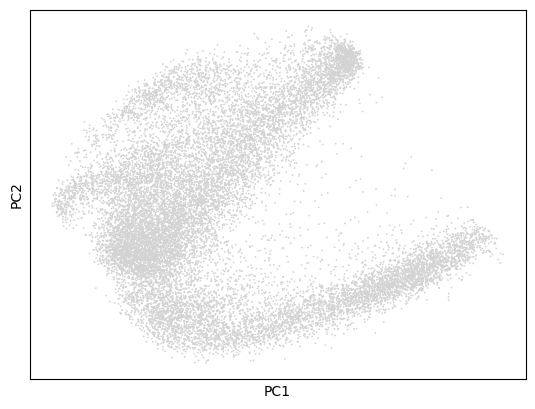

In [71]:
sc.pl.pca(adata_z)

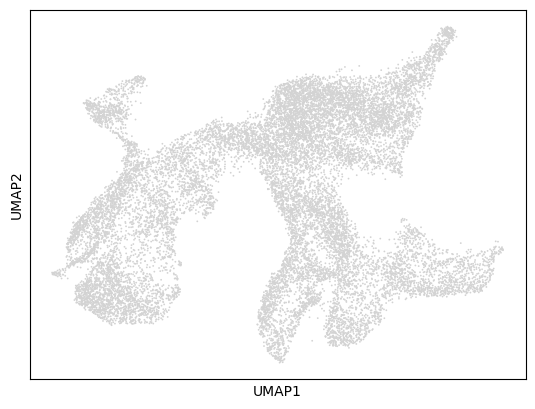

In [72]:
sc.pl.umap(adata_z)

**Real versus generated**

In [73]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


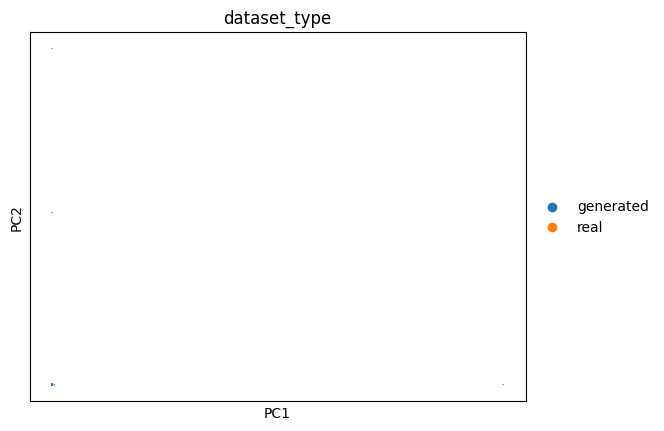

In [74]:
sc.pl.pca(adata, color="dataset_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


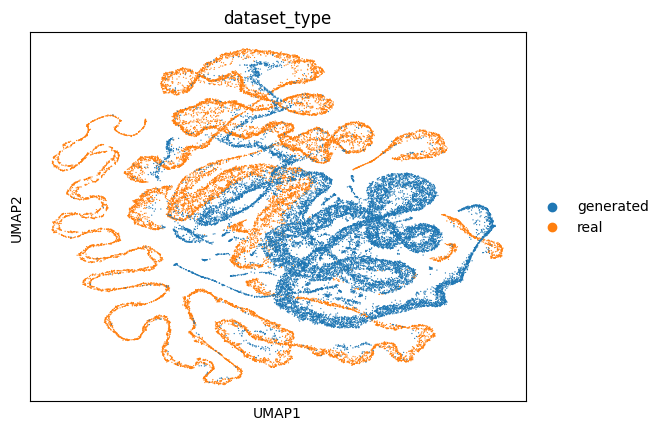

In [75]:
sc.pl.umap(adata, color="dataset_type")

(array([1426.,   36.,   20.,   23.,   14.,   18.,   16.,   20.,   21.,
         406.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

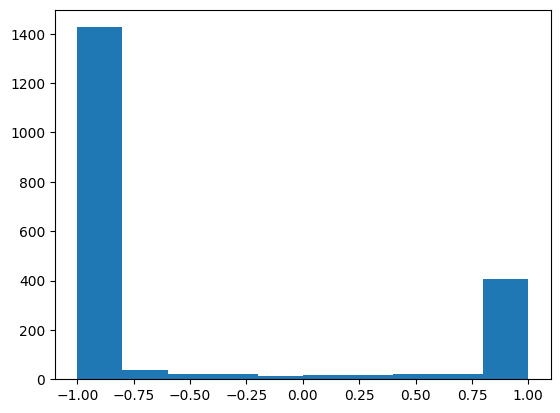

In [76]:
import matplotlib.pyplot as plt
plt.hist(Z_enc[0].ravel())

In [43]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer_trained/d7edf768-e1dc-43f1-b610-0239b697ee0a/checkpoints/last.ckpt")


In [44]:
ckpt['hyper_parameters']

{'denoising_model': MLPTimeStep(
   (net_in): Linear(in_features=2000, out_features=256, bias=True)
   (down_blocks): ModuleList(
     (0): ResnetBlock(
       (net1): Sequential(
         (0): Linear(in_features=256, out_features=128, bias=True)
         (1): SiLU()
         (2): Linear(in_features=128, out_features=128, bias=True)
       )
       (net2): Sequential(
         (0): SiLU()
         (1): Linear(in_features=130, out_features=128, bias=True)
       )
       (skip_proj): Linear(in_features=256, out_features=128, bias=True)
     )
     (1): ResnetBlock(
       (net1): Sequential(
         (0): Linear(in_features=128, out_features=64, bias=True)
         (1): SiLU()
         (2): Linear(in_features=64, out_features=64, bias=True)
       )
       (net2): Sequential(
         (0): SiLU()
         (1): Linear(in_features=66, out_features=64, bias=True)
       )
       (skip_proj): Linear(in_features=128, out_features=64, bias=True)
     )
   )
   (up_blocks): ModuleList(
     (0